# Models

## GloVe

In [1]:
!pip install spacy
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-06-03 19:10:34.899307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 19:10:37.488034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
import spacy

glove_model = spacy.load('en_core_web_md')

def word_embedding_glove(sentence):
  return glove_model(sentence).vector

## FastText
Skipping for now, take way too much RAM

## ELMo

In [3]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install numpy
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=76ff626a845cfcb2671a0234e4a68972b3e8f99b0397ff07971c3761d68791b1
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

elmo_model = hub.load("https://tfhub.dev/google/elmo/3")
tf.compat.v1.enable_eager_execution()

def word_embedding_elmo(sentence):
    embeddings = elmo_model.signatures["default"](tf.constant([sentence]))["default"]
    return embeddings.numpy().squeeze()

## BERT

In [5]:
!pip install transformers 
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Splitting the sentence is too time consuming

In [33]:
from transformers import BertModel, BertTokenizer
import torch

# Load BERT model and tokenizer
model_name = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def word_embedding_bert(sentence):
  tokens = tokenizer.encode(sentence, add_special_tokens=True, max_length=512, truncation=True)
  ids = torch.tensor(tokens).unsqueeze(0)
  with torch.no_grad():
    return bert_model(ids).last_hidden_state.mean(dim=1).squeeze()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## GPT

In [7]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt_model = GPT2Model.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def word_embedding_gpt(sentence):
    encoded = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
      outputs = gpt_model(**encoded)
      return outputs.last_hidden_state.mean(dim=1).numpy()

# Scores

In [9]:
models = ['glove', 'elmo', 'bert', 'gpt']

## Cosine Similarity

In [10]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# [-1, 1]. higher value -> higher similarity
def get_cosine_similarity(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model in ['fasttext', 'glove', 'bert']:
    return cosine_similarity(job_embedding.reshape(1, -1), resume_embedding.reshape(1, -1))[0, 0]
    
  elif model == 'elmo':
    return cosine_similarity([job_embedding], [resume_embedding])[0][0]

  # GPT model
  else:
    return cosine_similarity(job_embedding, resume_embedding)[0][0]

## Eucledian Distance

In [12]:
!pip install sklearn
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances

# non-negative value, lower the value -> higher the similarity
def get_eucledian_distance(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model in ['fasttext', 'elmo']:
    return euclidean(job_embedding, resume_embedding)
  
  # GloVe, BERT, or GPT
  else:
    return np.linalg.norm(job_embedding - resume_embedding)

## Pearson Correlation Coefficient

In [14]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from scipy.stats import pearsonr

# -1 to 1. -1 perfect negative linear relationship, 0 none, 1 perfect positive
def get_pearson_coefficient(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model == 'gpt':
    coeff, _ = pearsonr(job_embedding[0], resume_embedding[0])
    return coeff
  
  else:
    coeff, _ = pearsonr(job_embedding, resume_embedding)
    return coeff
    

## Manhattan Distance

In [16]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from scipy.spatial.distance import cityblock

max_length = 10000

# non-negative. higher value -> less similar
def get_manhattan_distance(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model in ['fasttext', 'glove', 'elmo']:
    return cityblock(job_embedding, resume_embedding)

  # BERT or GPT
  else:
    job_embedding = np.pad(job_embedding, (0, max_length - len(job_embedding)))
    resume_embedding = np.pad(resume_embedding, (0, max_length - len(resume_embedding)))
    return np.linalg.norm(job_embedding - resume_embedding, ord=1)

# Main

In [18]:
# Steps:
# 1. Job Desc
# 2. Get n random resumes
# 3. For each, generate the dataframe w models and scores
# 4. Rank the n resumes
# 5. TDIDF for each of them
# 
# Helpers
# 1. WordCloud for each resume
# 2. TDIDF WordCloud

In [19]:
import os
from google.colab import drive

In [20]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [21]:
INPUT_FOLDER = '/content/gdrive/Shareddrives/CSE 144 DATA/DATA'

In [22]:
import pandas as pd
import re
import nltk

In [23]:
# Read the Datasets
jobs_ds = pd.read_csv(INPUT_FOLDER + '/Final Job Dataset.csv', encoding='utf-8')
resume_ds = pd.read_csv(INPUT_FOLDER + '/Clean Resume Guara.csv', encoding='utf-8')

In [24]:
jobs_ds.head(1)

,Job Title,Job Description,Job Type,Location,City,State,Country,Zip Code,Company Name,Sector
0,Shift Manager,LOOKING TOP PERFORMERS GROW US Del Taco needs ...,NaN,"Mission Hills, CA 91345",Mission Hills,CA,United States,91345,Del Taco LLC,NaN


In [25]:
resume_ds.head(1)

,Unnamed: 0,Category,Resume
0,0,Data Science,Skills Programming Languages Python pandas num...


In [26]:
jobs_len = jobs_ds.shape[0]
resume_len = resume_ds.shape[0]

In [27]:
import random

In [28]:
job_id = random.randint(0, jobs_len-1)                             # Select a random job description

num_resumes = 10                                                   # Number of resumes to sample
resume_ids = random.sample(range(0, resume_len-1), num_resumes)    # Select random resumes

In [29]:
job_description     = jobs_ds['Job Description'][job_id]
resume_descriptions = [resume_ds['Resume'][i] for i in resume_ids]

### Get scores

In [30]:
# Return a formatted DataFrame, given a dictionary
def dict_to_df(result_dict):
  # Rename Rows
  result_dict['GPT'] = result_dict.pop('gpt')
  result_dict['BERT'] = result_dict.pop('bert')
  result_dict['GloVe'] = result_dict.pop('glove')
  result_dict['ELMo'] = result_dict.pop('elmo')

  # Create the dataframe
  result_df  = pd.DataFrame.from_dict(result_dict, orient='index')
  result_df.columns = ['Cosine Similarity', 'Eucledian Distance', 'Pearson Correlation Coefficient', 'Manhattan Distance', 'Weighted Combined Score']

  return result_df

In [31]:
all_candidates_result_df = []

# Generates the resulting dataframes (might take about 6-7 mins for 10 resumes)
def generate_df_results():

  # get embeddings for job description
  job_embeddings = {
                    'bert': word_embedding_bert(job_description), 
                    'elmo' : word_embedding_elmo(job_description),
                    'gpt'  : word_embedding_gpt(job_description),
                    'glove' : word_embedding_glove(job_description)
                    }

  resume_embeddings = {}

  for idx, resume in enumerate(resume_descriptions):
    print('Resume no. : ', idx)

    result_dict = {}

    # get embeddings by each model
    resume_embeddings['bert']  = word_embedding_bert(resume)
    resume_embeddings['gpt']   = word_embedding_gpt(resume)
    resume_embeddings['elmo']  = word_embedding_elmo(resume)
    resume_embeddings['glove'] = word_embedding_glove(resume)

    # loop over each model, and get all scores for that model
    for model in models:
      cos_sim    = get_cosine_similarity(job_embeddings[model], resume_embeddings[model], model)
      euc_dis    = get_eucledian_distance(job_embeddings[model], resume_embeddings[model], model)
      pear_coeff = get_pearson_coefficient(job_embeddings[model], resume_embeddings[model], model)
      manh_dis   = get_manhattan_distance(job_embeddings[model], resume_embeddings[model], model)

      result_dict[model] = [cos_sim, euc_dis, pear_coeff, manh_dis,
                            0+cos_sim-euc_dis+pear_coeff-manh_dis]  # total score, higher the better
    
    all_candidates_result_df.append(dict_to_df(result_dict))


In [34]:
generate_df_results()

Resume no. :  0
Resume no. :  1
Resume no. :  2
Resume no. :  3
Resume no. :  4
Resume no. :  5
Resume no. :  6
Resume no. :  7
Resume no. :  8
Resume no. :  9


In [35]:
# See dataframes of all resumes
def df_results():
  for i in range(len(all_candidates_result_df)):
    print('DF OF RESUME #', i)
    display(all_candidates_result_df[i])
    print()

In [36]:
df_results()

DF OF RESUME # 0


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.998130,16.547997,0.998125,12.074493,-26.626235
BERT,0.787362,5.772474,0.787333,146.488556,-150.686335
GloVe,0.729890,17.905483,0.729925,251.175476,-267.621144
ELMo,0.587958,9.344110,0.588518,233.650818,-241.818451



DF OF RESUME # 1


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.998981,7.935717,0.998978,5.547115,-11.484873
BERT,0.847562,4.664454,0.847526,119.784729,-122.754096
GloVe,0.733513,17.835316,0.733567,248.000031,-264.368266
ELMo,0.629006,8.636846,0.630454,214.435547,-221.812932



DF OF RESUME # 2


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.997681,29.794880,0.997674,23.389214,-51.188738
BERT,0.853606,4.733494,0.853607,118.833244,-121.859526
GloVe,0.757341,17.601114,0.757537,246.689941,-262.776178
ELMo,0.694951,8.133287,0.695314,203.350037,-210.093059



DF OF RESUME # 3


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999870,3.873575,0.999870,2.889458,-4.763293
BERT,0.889394,4.025311,0.889380,100.284683,-102.531220
GloVe,0.882970,12.401199,0.882965,174.032043,-184.667307
ELMo,0.724353,7.598750,0.724377,189.936188,-196.086208



DF OF RESUME # 4


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999808,5.464364,0.999808,4.511925,-7.976673
BERT,0.885217,4.165237,0.885214,104.124878,-106.519684
GloVe,0.872594,12.825476,0.872707,173.980560,-185.060735
ELMo,0.775372,6.933862,0.775362,172.971268,-178.354396



DF OF RESUME # 5


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999759,7.920433,0.999758,6.016319,-11.937235
BERT,0.891486,4.182833,0.891488,105.727783,-108.127642
GloVe,0.908840,10.955814,0.908946,154.019897,-163.157926
ELMo,0.806919,6.406907,0.806949,156.174957,-160.967996



DF OF RESUME # 6


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999436,8.945441,0.999434,5.749084,-12.695656
BERT,0.862032,4.466496,0.862002,112.543716,-115.286178
GloVe,0.847807,14.276831,0.847822,199.983978,-212.565179
ELMo,0.637231,8.453218,0.637284,213.919250,-221.097953



DF OF RESUME # 7


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999808,5.464364,0.999808,4.511925,-7.976673
BERT,0.885217,4.165237,0.885214,104.124878,-106.519684
GloVe,0.872594,12.825476,0.872707,173.980560,-185.060735
ELMo,0.775372,6.933862,0.775362,172.971268,-178.354396



DF OF RESUME # 8


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999792,3.113404,0.999792,1.610998,-2.724818
BERT,0.871497,4.371066,0.871481,109.228714,-111.856802
GloVe,0.808308,15.391482,0.808411,214.277496,-228.052259
ELMo,0.644041,8.677385,0.644328,213.946686,-221.335702



DF OF RESUME # 9


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999781,7.131653,0.999780,5.343330,-10.475422
BERT,0.895407,4.054412,0.895399,102.320587,-104.584193
GloVe,0.912098,10.745376,0.912109,146.881256,-155.802425
ELMo,0.755214,7.252080,0.755354,176.081314,-181.822826


### Rank the resumes

In [38]:
def rank_resumes():
  sum_array = []
  for i in range(len(all_candidates_result_df)):
    sum_array.append(all_candidates_result_df[i]['Weighted Combined Score'].sum())

  sorted_array = sorted(enumerate(sum_array), key=lambda x: x[1], reverse=True)
  
  print('Following are the Best Matching Resume(s): ')
  for idx, score in sorted_array:
    print(f'Resume #{idx}\t:\t{score}')

In [39]:
rank_resumes()

Following are the Best Matching Resume(s): 
Resume #5	:	-444.19079963004924
Resume #9	:	-452.68486568145005
Resume #4	:	-477.91148772414624
Resume #7	:	-477.91148772414624
Resume #3	:	-488.04802876048126
Resume #6	:	-561.6449665836078
Resume #8	:	-563.9695805231174
Resume #1	:	-620.4201664133564
Resume #2	:	-645.9175004505431
Resume #0	:	-686.7521641815111


### TF-IDF Visualizer

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Calculate TFIDF Scores
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(resume_descriptions)
feature_names = vectorizer.get_feature_names_out()

In [41]:
# print stats of tfidf
def tfidf_stats():

  # Print for each resume, how important a word is
  # Print the TF-IDF scores for each term in each document
  all_doc_list = []
  for doc_idx, doc in enumerate(resume_descriptions):
      feature_index = tfidf_matrix[doc_idx].nonzero()[1]
      tfidf_scores = zip(feature_index, [tfidf_matrix[doc_idx, x] for x in feature_index])
      cur_doc_list = []
      for term_idx, score in tfidf_scores:
          cur_doc_list.append((feature_names[term_idx], score))
      all_doc_list.append(sorted(cur_doc_list, key=lambda x: x[1]))
  
  print('Words w their TFIDF Scores')
  print()
  for idx, doc in enumerate(all_doc_list):
    print(f'Resume #{idx}\t:', doc)

In [42]:
tfidf_stats()

Words w their TFIDF Scores

Resume #0	: [('skill', 0.03935934937931754), ('education', 0.043110696045641536), ('monthscompany', 0.04725761739220298), ('maharashtra', 0.04725761739220298), ('india', 0.05189348104355918), ('months', 0.05189348104355918), ('technology', 0.06321646024335498), ('2016', 0.07039251809658932), ('academy', 0.07917530309450697), ('center', 0.07917530309450697), ('design', 0.07917530309450697), ('ssc', 0.07917530309450697), ('2010', 0.07917530309450697), ('surfing', 0.09049828229430275), ('interest', 0.09049828229430275), ('personal', 0.09049828229430275), ('trainer', 0.09049828229430275), ('information', 0.09049828229430275), ('exprience', 0.09451523478440596), ('working', 0.10378696208711836), ('road', 0.10645712514545476), ('charni', 0.10645712514545476), ('aptech', 0.10645712514545476), ('epi', 0.10645712514545476), ('cricket', 0.10645712514545476), ('playing', 0.10645712514545476), ('movie', 0.10645712514545476), ('watching', 0.10645712514545476), ('music', 

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# make wordclouds of each resume according to their tfidf scores
def make_tfidf_clouds():

  for i, resume in enumerate(resume_descriptions):
      tfidf_scores = tfidf_matrix[i].toarray().flatten()
      word_scores = dict(zip(feature_names, tfidf_scores))

      wordcloud = WordCloud(width=300, height=200, background_color='white').generate_from_frequencies(word_scores)

      plt.figure(figsize=(6, 4))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis('off')
      plt.title(f'Resume #{i}')

      # Show the plot
      plt.show()


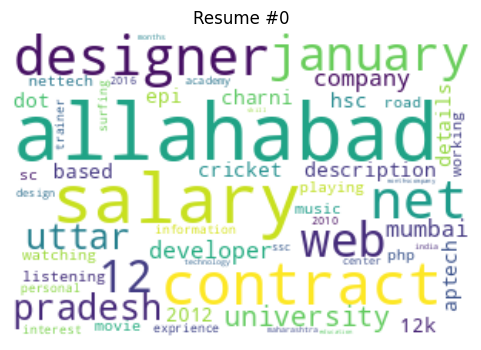

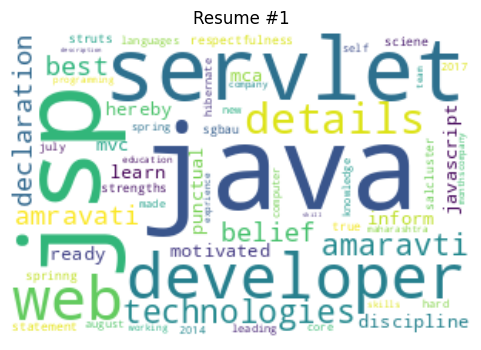

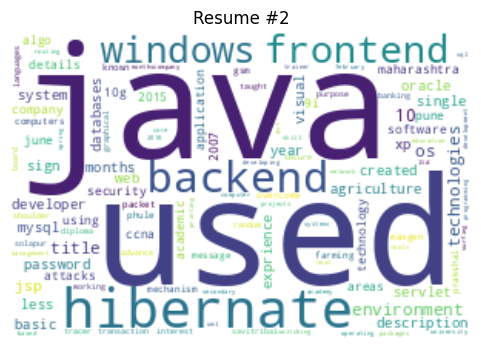

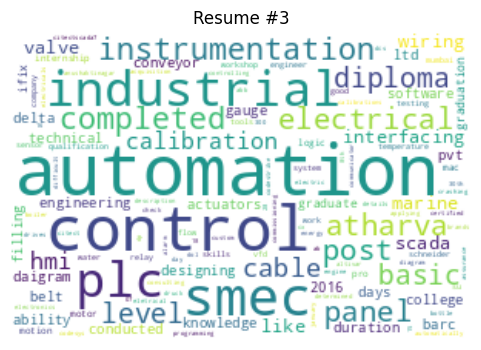

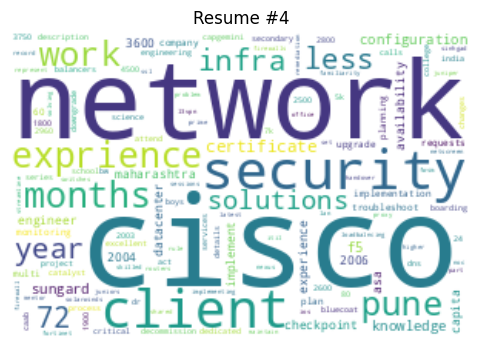

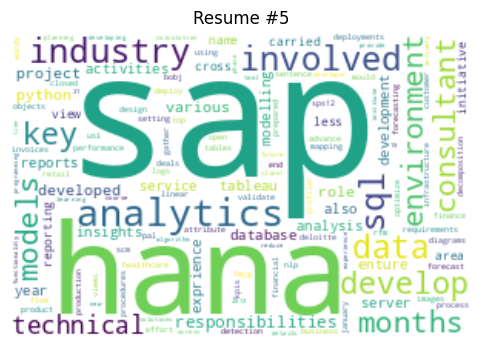

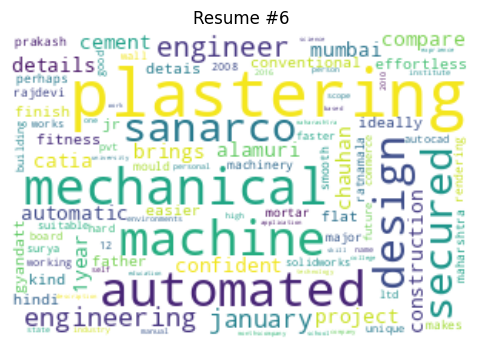

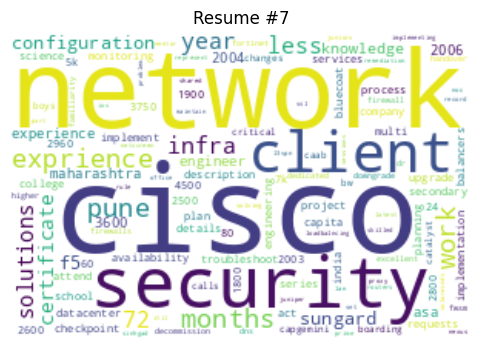

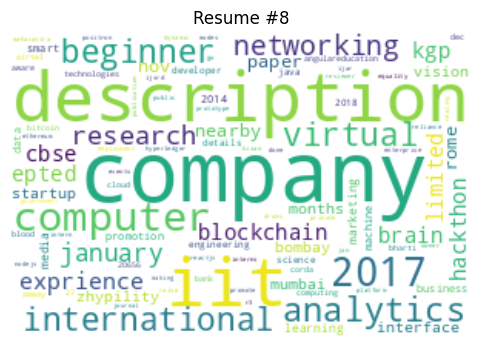

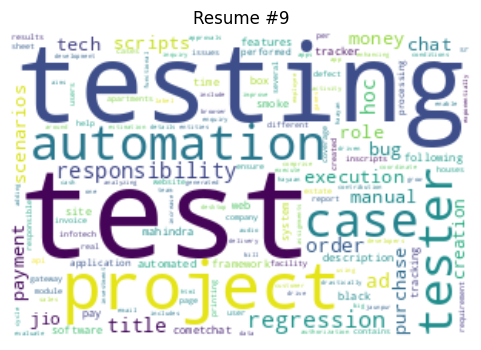

In [44]:
make_tfidf_clouds()

In [45]:
def wordcloud_tfidf_comb():

  word_scores = tfidf_matrix.sum(axis=0).A1
  word_scores_dict = dict(zip(feature_names, word_scores))
  wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_scores_dict)

  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title("Word Cloud of TF-IDF Resumes")

  # Show the plot
  plt.show()

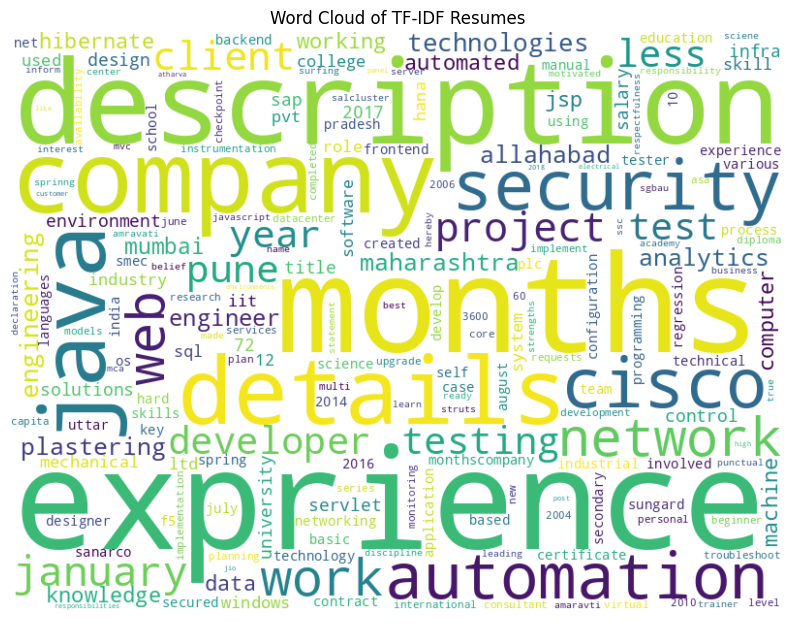

In [46]:
wordcloud_tfidf_comb()